In [1]:
import os
import requests
import pandas as pd
import numpy as np

import matplotlib

In [11]:
from tqdm import tqdm
tqdm.pandas()

In [2]:
from dotenv import load_dotenv

In [3]:
load_dotenv()

True

In [4]:
GOOGLE_MAPS_API_KEY = os.getenv('GOOGLE_MAPS_API_KEY')

In [5]:
df = pd.read_csv('data/venues_OM_MS.csv')

In [55]:
def search_google_maps(q):
    url = 'https://places.googleapis.com/v1/places:searchText'
    field_mask = 'places.name,places.id,places.types,places.formattedAddress,places.location,places.viewport,places.rating,places.googleMapsUri,places.websiteUri,places.businessStatus,places.userRatingCount,places.primaryType,places.shortFormattedAddress,places.regularOpeningHours,places.displayName,places.attributions,places.currentOpeningHours,places.internationalPhoneNumber'
    headers = {
        "X-Goog-FieldMask": field_mask,
        "Content-Type": "application/json",
    }
    json_body = {
        "textQuery": q,
    }
    params = {
        "key": GOOGLE_MAPS_API_KEY,
    }
    response = requests.post(url, headers=headers, json=json_body, params=params)
    return response

In [86]:
df['google_maps_status_code'] = None
df['google_maps_response_json'] = None

In [6]:
df.names = df.names.apply(eval)
df.address_locality = df.address_locality.apply(eval)
df.coordinates = df.coordinates.apply(eval)

In [91]:
for i, row in df.iterrows():
    if row['google_maps_status_code'] != 200:
        name = row['names'][0]

        q = name
        if len(row['address_locality']) > 0:
            city = row['address_locality'][0]
            q = f'{q} {city}'
        print(f'Searching {i}: {q}')
        r = search_google_maps(q)
        response = r.json()
        print('N results:', len(response.get('places', [])))
        df.at[i, 'google_maps_status_code'] = r.status_code
        df.at[i, 'google_maps_response_json'] = response

Searching 5: OM YOGA Komárno Komárno
N results: 1
Searching 6: Klzisko
N results: 20
Searching 7: Life Tilt Poker Komárno
N results: 0
Searching 8: LifeSport Komárno
N results: 1
Searching 9: Jungle DANCE Studio Komárno
N results: 1
Searching 10: Ildi-Pilates Komárno
N results: 3
Searching 11: Fedett Uszoda Komárno Komárno
N results: 1
Searching 12: Plaváreň Komárno
N results: 1
Searching 13: D-Gym&Ďumbi training Komarnom
N results: 16
Searching 14: BlackCrossGym - Crossfit Komárno
N results: 1
Searching 15: Szayka KEMPO Dojo Komárno
N results: 1
Searching 16: Bowling Centrum Komárno
N results: 1
Searching 17: DEVIL CLUB Komárno
N results: 1
Searching 18: Ramses bar & biliard Komárno
N results: 1
Searching 19: Zero Yoga  Komárno & Hormon Yoga Center Zlaté Moravce
N results: 1
Searching 20: Squash & Fitness Komárno Komárno
N results: 1
Searching 21: MAX GYM Komárno, Špitálska 19 Komárno
N results: 1
Searching 22: Street Workout Komarno Komárno
N results: 2
Searching 23: Diving-Shop.sk F

In [94]:
df.to_csv('data/venues_OM_MS_w_google_data.csv', index=False)

In [7]:
df = pd.read_csv('data/venues_OM_MS_w_google_data.csv')

In [8]:
df.names = df.names.apply(eval)
df.address_locality = df.address_locality.apply(eval)
df.coordinates = df.coordinates.apply(eval)
df.google_maps_response_json = df.google_maps_response_json.apply(eval)

In [32]:
def compute_distance(row):

    coords = [float(x) for x in row['coordinates']]
    places = row['google_maps_response_json'].get('places', [])
    if len(places) == 0:
        return -1
    google_coords = [places[0]['location']['latitude'], places[0]['location']['longitude']]

    distance = (coords[0] - google_coords[0])**2 + (coords[1] - google_coords[1])**2
    return distance

import math

# Distance in meters
def haversine_distance(row):

    coords = [float(x) for x in row['coordinates']]
    places = row['google_maps_response_json'].get('places', [])
    if len(places) == 0:
        return -1
    google_coords = [places[0]['location']['latitude'], places[0]['location']['longitude']]

    R = 6371000  # Earth's radius in meters

    lat1, lon1 = coords[0], coords[1]
    lat2, lon2 = google_coords[0], google_coords[1]

    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    distance = R * c
    return distance

In [13]:
df['distance'] = df.progress_apply(compute_distance, axis=1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4161/4161 [00:00<00:00, 104492.22it/s]


In [33]:
df['haversine_distance'] = df.progress_apply(haversine_distance, axis=1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4161/4161 [00:00<00:00, 85169.46it/s]


In [51]:
def extract_google_properties(google_response):
    if not google_response:
        return None, None, None, None

    place = google_response['places'][0]
    name = place['displayName']['text']
    formatted_address = place.get('shortFormattedAddress')
    phone_number = place.get('internationalPhoneNumber')
    website = place.get('websiteUri')

    return name, formatted_address, phone_number, website
    

In [52]:
df['google_name'], df['google_address'], df['google_phone'], df['google_website'] = zip(*df.google_maps_response_json.progress_apply(extract_google_properties))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4161/4161 [00:00<00:00, 305931.93it/s]


In [67]:
name_ok = df.apply(lambda row: isinstance(row['google_name'], str) and row['google_name'].lower() in [n.lower() for n in row['names']], axis=1)
distance_ok = (df['haversine_distance'] < 100) & (df['haversine_distance'] >= 0)

In [71]:
print(sum(name_ok))
print(sum(distance_ok))
print(sum(name_ok | distance_ok))

1060
2201
2508


In [38]:
sum((df.haversine_distance < 100) & (df.haversine_distance >= 0))

2201

<Axes: >

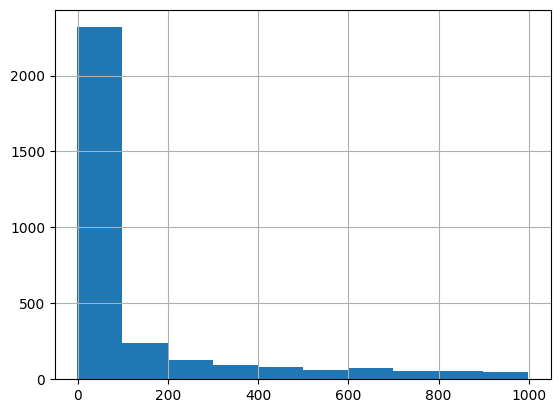

In [39]:
df['haversine_distance'][df.haversine_distance < 1000].hist()

<Axes: >

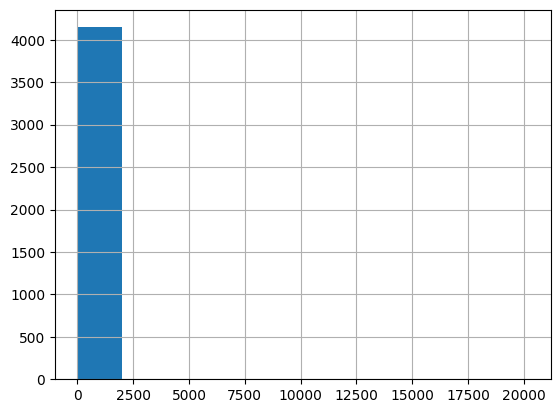

In [14]:
df['distance'].hist()

In [120]:
df.distance.describe()

count    4.161000e+03
mean     3.426757e+01
std      6.473298e+02
min     -1.000000e+00
25%      2.365840e-08
50%      4.345919e-07
75%      1.103884e-04
max      2.020589e+04
Name: distance, dtype: float64

In [19]:
', '.join([str(c) for c in df.coordinates[0]])

'84.3775551, -81.51684'

In [30]:
import math

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371000  # Earth's radius in meters

    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))

    distance = R * c
    return distance

In [31]:
for i, row in df.sort_values('distance').iterrows():
    if row['distance'] == -1:
        continue
        
    google_coords = [row['google_maps_response_json']['places'][0]['location']['latitude'], row['google_maps_response_json']['places'][0]['location']['longitude']]
    print(row['names'])
    print(row['address_freeform'])
    print(row['google_maps_response_json']['places'][0]['displayName']['text'])
    print(row['google_maps_response_json']['places'][0]['formattedAddress'])
    print('DIST', row['distance'])
    print('ORIG:', ', '.join([str(c) for c in row['coordinates']]))
    print('GOOG:', ', '.join([str(c) for c in google_coords]))
    print('METERS:', haversine_distance(*google_coords, *row['coordinates']))
    # print('ORIG:', ', '.join([str(c) for c in df.coordinates[0]]))
    print('-----------')

['Kaďa NA MIERU']
['[noname] 112']
Kaďa NA MIERU
noname 112, 956 32 Livinské Opatovce, Slovakia
DIST 0.0
ORIG: 48.6460436, 18.2319346
GOOG: 48.6460436, 18.2319346
METERS: 0.0
-----------
['HANSCRAFT - vírivky a sauny']
['Výhonská 7532/1']
HANSCRAFT - vírivky a sauny
Výhonská 7532/1, 831 06 Bratislava-Rača, Slovakia
DIST 0.0
ORIG: 48.2115133, 17.1589499
GOOG: 48.2115133, 17.1589499
METERS: 0.0
-----------
['Fitnes centrum Forma club - 3XXL s.r.o.']
['Levočská 27']
Fitnes centrum Forma club - 3XXL s.r.o.
Levočská 27, 064 01 Stará Ľubovňa, Slovakia
DIST 1.262177448353619e-29
ORIG: 49.2906358, 20.6902599
GOOG: 49.2906358, 20.690259899999997
METERS: 2.3066594655743837e-10
-----------
['Rafting Ružomberok']
['J. Kačku']
Rafting Ruzomberok
J. Kačku, 034 01 Ružomberok, Slovakia
DIST 1.262177448353619e-29
ORIG: 49.086276, 19.303128
GOOG: 49.086276, 19.303127999999997
METERS: 2.316206707831635e-10
-----------
['Fitko - lifestyle & performance center']
['Lastomírska 6968/7A', 'Lastomírska 7A']
Fi

In [80]:
for i, row in df[~(name_ok | distance_ok)].sort_values('haversine_distance').iterrows():
    if row['distance'] == -1:
        continue
        
    google_coords = [row['google_maps_response_json']['places'][0]['location']['latitude'], row['google_maps_response_json']['places'][0]['location']['longitude']]
    print(row['names'])
    print(row['google_maps_response_json']['places'][0]['displayName']['text'])
    print('ADDR', row['address_freeform'])
    print('GOOG', row['google_address'])
    # print(row['google_maps_response_json']['places'][0]['formattedAddress'])
    # print('DIST', row['distance'])
    # print('ORIG:', ', '.join([str(c) for c in row['coordinates']]))
    # print('GOOG:', ', '.join([str(c) for c in google_coords]))
    print('METERS:', row['haversine_distance'])
    # print('ORIG:', ', '.join([str(c) for c in df.coordinates[0]]))
    print('-----------')

['Pitbike Šariš']
Motokáry Šariš
ADDR ['Železničná 433/9, 082 21 Veľký Šariš, Slovenská Republika']
GOOG Železničná 433/9, Veľký Šariš
METERS: 100.2366854907979
-----------
['SAUNIA AUPARK Bratislava']
Saunia
ADDR ['Einsteinova 18']
GOOG Aupark, Einsteinova 18, Petržalka
METERS: 100.42502181365937
-----------
['Motokáry Trebatice']
Motokárová dráha Trebatice
ADDR ['Dráhová']
GOOG Dráhová 192/5, Trebatice
METERS: 100.42691169506347
-----------
['Areál športu a relaxu Aquarea Čierna Voda']
Aquarea Čierna Voda
ADDR ['Čierna Voda']
GOOG Čierny Brod
METERS: 100.93731767561823
-----------
['ZŠ J. Fándlyho BAZÉN']
Plaváreň ZŠ J. Fándlyho
ADDR ['Fándlyho 763/7A']
GOOG Sereď
METERS: 101.46066188149979
-----------
['Termálne kúpalisko Podhájska']
Thermal spa
ADDR ['Podhorská 493/32']
GOOG Podhájska 493, Podhájska
METERS: 101.6304581929593
-----------
['Iguana Disco']
Disco Bar - IGUANA
ADDR ['Partizánska 67/14']
GOOG Partizánska 67, Tomášovce
METERS: 101.84556696761217
-----------
['Futbalový št

In [41]:
len(df)

4161